### Dataset 과 DataLoder

- 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어려울 수 있다.<br>
더 나은 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를<br>
모델 학습 코드로부터 분리하는 것이 이상적이다.<br>
PyTorch는 `torch.utils.data.Dataset`과 `torch.utils.data.DataLoader`의<br>
두 가지 데이터 기본 요소를 제공하여 미리 준비해둔(pre-loaded) 데이터셋 뿐만 아니라<br>
가지고 있는 데이터를 사용할 수 있도록 한다.
    - Dataset: 샘플과 정답(label)을 저장한다.
    - DataLoader: Dataset을 샘플에 쉽게 접근할 수 있도록 순회(반복) 가능한 객체<br>
    (iterable)로 감싼다.

In [13]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="./data",  # 학습/테스트 데이터가 저장되는 경로
    train=True,  # 학습용 또는 테스트용 데이터셋 여부를 지정, 기본값 = True
    download=True,  # root에 데이터가 없는 경우 인터넷에서 다운로드, 기본값 = False
    transform=ToTensor()  # 또다른 매개변수인 target_transform와 함께 각각 특징(feature)과 정답(label)의 변형을 지정
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



#### 데이터 순회 & 시각화

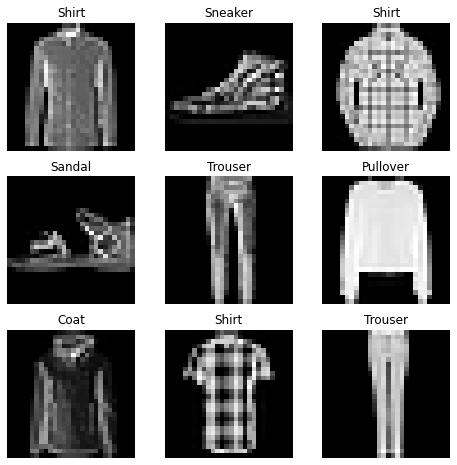

In [11]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols = rows = 3
for i in range(1, cols * rows + 1):
    # item() 메서드를 사용하여 python 숫자 값으로 변환
    sample_index = torch.randint(len(training_data), size=(1,)).item()
    image, label = training_data[sample_index]
    figure.add_subplot(rows, cols, i, title=labels_map[label]).axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()
    
    

#### 사용자 정의 데이터셋 만들기
- 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다.
    1. \__init__
    2. \__len__
    3. \__getitem__

In [16]:
import os

from torch.utils.data import Dataset
from torchvision.io import read_image

import pandas as pd


class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, image_dir, transform=None, target_transform=None):
        '''
        __init__ 함수는 Dataset 객체(인스턴스)가 생성될 때 한 번만 실행된다.\n
        여기서는 이미지와 주석 파일(annotation_file)이 포함된 경로(dir)와 두가지 변형(transform)을 초기화한다.
        
        labels.csv 파일 예시는 다음과 같다.
        
            tshirt1.jpg, 0\n
            tshirt2.jpg, 0\n
            ......\n
            ankleboot999.jpg, 9
        '''
        self.image_labels = pd.read_csv(annotations_file, names=["file_name", "label"])
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        '''
        __len__ 함수는 데이터셋의 샘플 개수를 반환한다.
        '''
        return len(self.image_labels)
    
    def __getitem__(self, index):
        '''
        __getitem__ 함수는 주어진 인덱스에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.\n
        인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, `read_image`를 사용하여 이미지를 텐서로 변환하고,\n
        `self.image_labels`의 csv 데이터로부터 해당하는 정답(label)을 가져오고,\n
        (해당하는 경우에) 변형 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전형으로 반환한다.
        '''
        image_path = os.path.join(self.image_dir, self.image_labels.iloc[index, 0])
        image = read_image(image_path)
        label = self.image_labels.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image":image, "label":label}
        return sample
        

#### DataLoader로 학습용 데이터 준비하기
- `Dataset`은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다.<br>
모델을 학습할 때, 일반적으로 샘플들을 "미니배치(minibatch)"로 전달하고,<br>
매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고,<br>
Python의 `multiprocessing`을 사용하여 데이터 검색 속도를 높이려고 한다.<br>
`DataLoader`는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

In [17]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### DataLoader를 통해 순회하기(iterate)
- `DataLoader`에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다.<br>
아래의 각 순회는 (각각 `batch_size=64`의 특징과 정답을 포함하는) `train_features`와 `train_labels`의<br>
묶음(batch)를 반환한다. `shuffle=True`로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


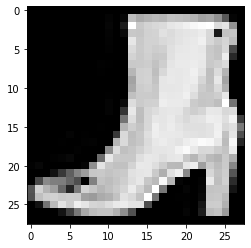

Label: 9


In [18]:
# 영상과 정답을 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")